In [1]:
import pandas as pd
pd.set_option('display.max_columns', 50)
import numpy as np
import tensorflow as tf
from sklearn.externals import joblib
from keras.models import load_model

Using TensorFlow backend.


# Data processing

## Load scaler and encoders

While using the scaler and encoders on new dataset, make sure the order of the PM values is the same with the example dataset (Ascend by alphabet).

In [2]:
min_max_scaler = joblib.load('encoders/Minmax_scaler')
autoencoder = load_model('encoders/encoder_1layer_75dims')
label_encoder = joblib.load('encoders/label_encoder')
onehot_encoder = joblib.load('encoders/onehot_encoder')

/usr/local/lib/python3.5/dist-packages/keras/engine/saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


## Data preprocessing

In [3]:
data = pd.read_csv('data/testset.csv')
dev_list = ['CHMON', 'STM64', 'OC192', 'STTP', 'STM4', 'STM16', 'NMCMON', 'OC48', 'OC12', 'OC3', 'FLEX', 'RAMAN']
data = data.drop(data[data['GROUPBYKEY'].isin(dev_list)].index)
data = data.fillna(0)

In [4]:
data.head()


,ID,TIME,LABEL,GROUPBYKEY,BBE-RS,CV-OTU,CV-S,DROPGAINAVG-OTS,DROPGAINMAX-OTS_DROPGAINMIN-OTS_-,E-CV,E-ES,E-INFRAMESERR_E-INFRAMES_/,E-OUTFRAMESERR_E-OUTFRAMES_/,E-UAS,ES-OTU,ES-RS,ES-S,OCH-OPRAVG,OCH-OPRMAX_OCH-OPRMIN_-,OCH-SPANLOSSAVG,OCH-SPANLOSSMAX_OCH-SPANLOSSMIN_-,OPINAVG-OTS,OPINMAX-OTS_OPINMIN-OTS_-,OPOUTAVG-OTS,OPOUTAVG-OTS_OPINAVG-OTS_-,OPOUTMAX-OTS_OPOUTMIN-OTS_-,OPRAVG-OCH,OPRAVG-OTS,OPRMAX-OCH_OPRMIN-OCH_-,OPRMAX-OTS_OPRMIN-OTS_-,OPTAVG-OCH,OPTAVG-OTS,OPTMAX-OCH_OPTMIN-OCH_-,OPTMAX-OTS_OPTMIN-OTS_-,ORLAVG-OTS,ORLMIN-OTS,OTU-CV,OTU-ES,OTU-QAVG,OTU-QSTDEV,PCS-CV,PCS-ES,PCS-UAS,QAVG-OTU,QSTDEV-OTU,RS-BBE,RS-ES,S-CV,S-ES,ALARM
0,Device86996,2019-02-27,IS-ANR,ETH10G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172802.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,2279.0,97.0,57802.0,0.0,0.0,0.0,0.0,0.0,0.0,Loss Of Frame
1,Device98491,2019-02-27,OOS-AU,ETH10G,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,172802.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,8.0,86344.0,0.0,0.0,0.0,0.0,0.0,0.0,Laser Off Far End Failure Triggered
2,Device64479,2019-01-04,IS,OPTMON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,12.78,0.0,0.37,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
3,Device94142,2019-02-11,IS,OTM,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,-8.31,0.00,0.5,0.00,0.0,0.00,0.0,0.0,0.0,0.0,0.0,0.0,12.99,0.04,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0
4,Device30622,2019-03-18,IS,OPTMON,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.00,0.0,-5.19,0.0,0.2,0.0,0.0,0.0,0.0,0.00,0.00,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0


In [5]:
data = data.drop(['ID','TIME','LABEL'], axis=1)

## Convert 45 PM values to 86 features

*45 PM values -> scaled -> autoencoder -> 75 features*

*GROUPBYKEY -> label_encoder -> onehot_encoder -> 11 features*

**Concatenate the 75 features with the 11 features to form 86 features**

In [6]:
label_encoder.classes_

array(['AMP', 'ETH', 'ETH10G', 'ETHN', 'ETTP', 'OPTMON', 'OSC', 'OTM',
       'OTM2', 'OTUTTP', 'PTP'], dtype='<U6')

In [7]:
data.iloc[:, 1:46] = min_max_scaler.transform(data.iloc[:, 1:46])
PMs = autoencoder.predict(data.iloc[:,1:46])
GBK = label_encoder.transform(np.reshape(data['GROUPBYKEY'].tolist(), [-1, 1]))
GBK = np.reshape(GBK, [-1, 1])
GBK = onehot_encoder.transform(GBK)
GBK = pd.DataFrame(GBK.toarray())
x_test = np.concatenate([GBK,PMs],axis=1)

/usr/local/lib/python3.5/dist-packages/sklearn/preprocessing/label.py:252: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


**Convert input data into a 3-D shape**

In [8]:
x_test = x_test.reshape([-1, x_test.shape[1], 1])

# Restore model and predict

**Load graph and restore parameters**

*number* in (1100, 1300, 3000, 3200, 3500), they are 5 models I trained

*number* stands for training epoches of each model

In [9]:
number = 1100
sess = tf.Session()
saver = tf.train.import_meta_graph('TF_models/mean_teacher-%s.meta'%str(number))
saver.restore(sess=sess, save_path='TF_models/mean_teacher-%s'%str(number))
graph = tf.get_default_graph()

INFO:tensorflow:Restoring parameters from TF_models/mean_teacher-1100


**Get input and output tensor**

In [10]:
try:
    input = graph.get_tensor_by_name('placeholders/Placeholder:0')
    output = graph.get_tensor_by_name('primary/fully_connected/add:0')
except:
    input = graph.get_tensor_by_name('placeholders/features:0')
    output = graph.get_tensor_by_name('output:0')

**Output and argmax the result**

In [11]:
out = sess.run([output], feed_dict={input : x_test})[0]

In [12]:
result = np.argmax(out,axis=1)
result = result.reshape([-1,1])        

# Test section

**This section is for dataset that has 'ALARM' column in it**

**Data sample with 'ALARM' that is '0' will be considered Normal, otherwise malfunction**

In [13]:
alarm_idx = data[data['ALARM'] != '0'].index
normal_idx = data[data['ALARM'] == '0'].index
data.loc[alarm_idx,['ALARM']] = 1
data.loc[normal_idx,['ALARM']] = 0
y_test = data['ALARM'].to_list()

In [14]:
from toolib.draw_cm import cm_metrix, cm_analysis
from sklearn.metrics import accuracy_score,classification_report

**Calculate the confusion matrix (cm) and plot the result**

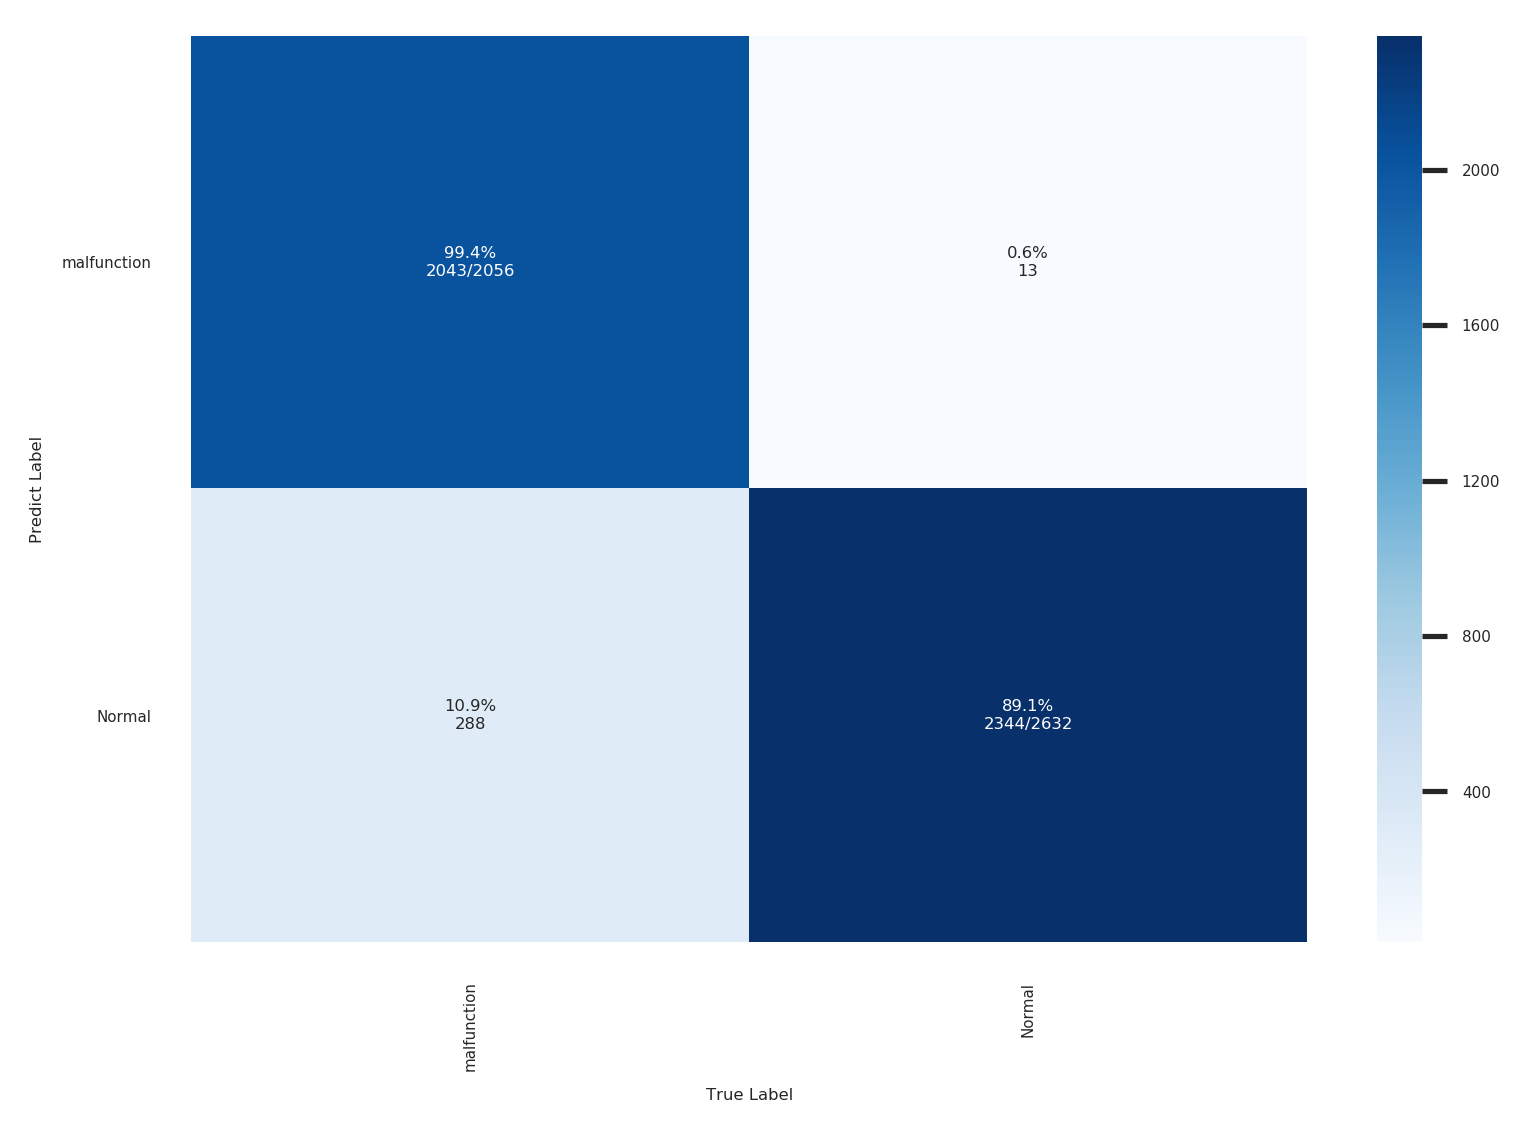

In [15]:
cm = cm_metrix(y_test=y_test, y_pred=result)
cm_analysis(cm,['Normal', 'malfunction'],precision=True)

**Accuracy**

In [16]:
accuracy = accuracy_score(y_true=y_test, y_pred=result)
print(accuracy)

0.9357935153583617


**Classification report**

In [17]:
print(classification_report(y_true=y_test, y_pred=result))

              precision    recall  f1-score   support

           0       0.89      0.99      0.94      2357
           1       0.99      0.88      0.93      2331

   micro avg       0.94      0.94      0.94      4688
   macro avg       0.94      0.94      0.94      4688
weighted avg       0.94      0.94      0.94      4688

